In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## Load and Pre-Process

In [2]:
order = [
    ["Flower", "ConeExpand"],
    ["OhMiniMap", "2DMiniMap+"],
    ["ThreeDMiniMap", "3DMiniMap"],
    ["GravityZone", "GravityZone+"],
]

In [11]:
####################################################################################################
# pre-process

root = "/Users/maslychm/projects/vr_selection/Assets/StreamingAssets/density_data/"

original_csv_links = [
    root + fn
    for fn in [
        "sr_sub2_1665156140.csv",
        "sr_sub3_1665169118.csv",
        "sr_sub4_1665171433.csv",
        "sr_sub5_1665177450.csv",
        "sr_sub6_1665181701.csv",
        "sr_sub7_1665429371.csv",
        "sr_sub8_1665435287.csv",
        "sr_sub9_1665447708.csv",
        "sr_sub10_1665494513.csv",
        "sr_sub11_1665499310.csv",
        "sr_sub12_1665522669.csv",
        "sr_sub13_1665531443.csv",
        "sr_sub14_1665584720.csv",
        "sr_sub15_1665591432.csv",
        "sr_sub16_1665620373.csv",
        "sr_sub17_1665623547.csv",
        "sr_sub18_1665671006.csv",
        "sr_sub19_1665677719.csv",
        "sr_sub20_1665682149.csv",
        "sr_sub21_1665688623.csv",
        "sr_sub22_1665701569.csv",
        "sr_sub23_1666893821.csv",
        "sr_sub24_1667230835.csv",
        "sr_sub25_1669269150.csv",
    ]
]

assert len(original_csv_links) == len(list(set(original_csv_links)))

csv_root = "/Users/maslychm/projects/vr_selection/density_data/"
processed_csv_links = []
for link in original_csv_links:
    df = pd.read_csv(link)

    # set global trial index between 1 and 120 (30 trials per density level)
    df["global_trial_idx"] = pd.Series(range(1, 121))

    # change density levels to strings
    df["density"] = df["density"].replace({1: "low", 2: "medium", 3: "high"})

    df.replace(order[0][0], order[0][1], inplace=True)
    df.replace(order[1][0], order[1][1], inplace=True)
    df.replace(order[2][0], order[2][1], inplace=True)
    df.replace(order[3][0], order[3][1], inplace=True)

    df["technique"] = df["technique"].replace({o[0]: o[1] for o in order})

    # format subject id
    sub_idx = link.split("sub")[-1].split("_")[0]

    processed_csv_link = csv_root + "sub_" + sub_idx + ".csv"
    df.to_csv(processed_csv_link, index=False)
    processed_csv_links.append(processed_csv_link)

del df

####################################################################################################
# load data

dataframes = [pd.read_csv(link) for link in processed_csv_links]
dfs = pd.concat(dataframes)

# drop trials where number of attemps is more than 1
# dfs = dfs[dfs["num_attempts"] == 1]

## TODO REMOVE ALL FIRST TRIALS PER TECHNIQUE

# drop rows where trial_time is over 20
# dfs = dfs[dfs["trial_time"] < 23]

# drop above 3 sdtev
# dfs = dfs[dfs["trial_time"] < dfs["trial_time"].mean() + 3 * dfs["trial_time"].std()]

dfs = dfs.reset_index()

# pre-process global trial index: mod global_trial_idx by 31
# dfs["global_trial_idx"] = dfs["global_trial_idx"] % 31

print(f"Number of rows: {len(dfs)}")

dfs.to_csv("all.csv", index=False)


Number of rows: 2880


In [4]:
# dfs

In [5]:
# # count number of trials with more than 1 attempt per condition
# for technique in dfs.technique.unique():
#     for trial_type in dfs.trial_type.unique():
        
#         # num attempts above 1
#         more_attempts_df = dfs[(dfs["technique"] == technique) & (dfs["trial_type"] == trial_type)]
#         more_attempts_df = more_attempts_df[more_attempts_df["num_attempts"] > 1]["num_attempts"]
#         print(technique, trial_type, more_attempts_df.count())

In [6]:
# ax = sns.catplot(data=dfs, x="trial_type", y="trial_time", col="technique", kind="violin", showfliers=False)

## Remove outliers per-technique-per-trial-type-per-density

In [4]:
# remove outliers per-techique per-trial-type per-density-level.
# this is NOT based on participants, but all participant's performance per condition

dfs_no_outliers_per_condition = pd.DataFrame()

for technique in dfs.technique.unique():
    tdfs = dfs[dfs["technique"] == technique]

    for trial_type in tdfs.trial_type.unique():
        ttdfs = tdfs[tdfs["trial_type"] == trial_type]

        for density in ttdfs.density.unique():
            dttdfs = ttdfs[ttdfs["density"] == density]

            # drop outliers which are above 3 standard deviations for trial time
            mean, stdev = dttdfs["trial_time"].mean(), dttdfs["trial_time"].std()
            cleandfs = dttdfs[dttdfs["trial_time"] < mean + 4 * stdev]
            dfs_no_outliers_per_condition = pd.concat([dfs_no_outliers_per_condition, cleandfs])

print(len(dfs_no_outliers_per_condition))

print("diff = ", len(dfs) - len(dfs_no_outliers_per_condition))
print("diff = ", (len(dfs) - len(dfs_no_outliers_per_condition)) / len(dfs) * 100, "%")

dfs_no_outliers_per_condition.to_csv("clean.csv", index=False)

2845
diff =  35
diff =  1.215277777777778 %


In [8]:
# dfs_no_outliers_per_condition

In [9]:
# # inspect before organizing by participant
# ax = sns.barplot(
#     data=dfs_no_outliers_per_condition, 
#     x="trial_type", 
#     y="trial_time", 
#     hue="technique",
#     hue_order=[o[0] for o in order],
#     order=["Search", "Repeat"],
#     ci=95,
# )

# handles, labels = ax.get_legend_handles_labels()
# labels = [o[1] for o in order]
# ax.legend(loc="lower left", handles=handles[:], labels=labels[:])

## (Optional) Condense multiple trials per condition down to a single line
We have: trial type (2), technique type (4), density level (3) X num_participants (24), which means
we will have 2 * 4 * 3 * 24 rows = 576 rows

In [10]:
"""This is commented out because it can be achieved by using the `groupby` method with `reset_index` at the end."""

# new_rows = []
# for technique in dfs_no_outliers_per_condition.technique.unique():
#     for trial_type in dfs_no_outliers_per_condition.trial_type.unique():
#         for density in dfs_no_outliers_per_condition.density.unique():
#             for sub in dfs_no_outliers_per_condition.subject_id.unique():
#                 df = dfs_no_outliers_per_condition[
#                     (dfs_no_outliers_per_condition["technique"] == technique) & 
#                     (dfs_no_outliers_per_condition["trial_type"] == trial_type) & 
#                     (dfs_no_outliers_per_condition["density"] == density) &
#                     (dfs_no_outliers_per_condition["subject_id"] == sub)
#                 ]

#                 new_row = {
#                     "technique": technique,
#                     "trial_type": trial_type,
#                     "density": density,
#                     "subject_id": sub,
#                     "trial_time": df["trial_time"].mean(),
#                 }
#                 new_rows.append(new_row)

# dfs_no_outliers_per_condition = pd.DataFrame(new_rows)

# dfs_no_outliers_per_condition.replace(order[0][0], order[0][1], inplace=True)
# dfs_no_outliers_per_condition.replace(order[1][0], order[1][1], inplace=True)
# dfs_no_outliers_per_condition.replace(order[2][0], order[2][1], inplace=True)
# dfs_no_outliers_per_condition.replace(order[3][0], order[3][1], inplace=True)

# print(len(dfs_no_outliers_per_condition))

'This is commented out because it can be achieved by using the `groupby` method with `reset_index` at the end.'

In [11]:
# dfs_no_outliers_per_condition

## Plot the first graph with two trial types and 4 techniques

In [38]:
new_rows = []
for trial_type in dfs_no_outliers_per_condition.trial_type.unique():

    for technique in dfs_no_outliers_per_condition.technique.unique():
        for subject in dfs_no_outliers_per_condition.subject_id.unique():
            density_values = []
            for density in dfs_no_outliers_per_condition.density.unique():
                value = dfs_no_outliers_per_condition[
                    (dfs_no_outliers_per_condition["trial_type"] == trial_type) &
                    (dfs_no_outliers_per_condition["technique"] == technique) &
                    (dfs_no_outliers_per_condition["subject_id"] == subject) &
                    (dfs_no_outliers_per_condition["density"] == density)
                ]["trial_time"].values.mean()
                density_values.append(value)
            density_mean = np.mean(density_values)
            row = {
                "trial_type": trial_type,
                "technique": technique,
                "subject_id": subject,
                "trial_time": density_mean,
            }
            new_rows.append(row)

df_for_first_plot = pd.DataFrame(new_rows)
df_for_first_plot.sort_values(by=["trial_type", "technique", "subject_id"], inplace=True)
df_for_first_plot.to_csv("df_for_first_plot.csv", index=False)

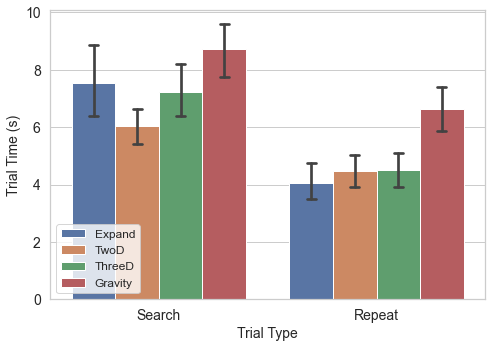

In [42]:
fig, ax = plt.subplots(figsize=(7, 5))

# plot condensed data
sns.barplot(
    data=df_for_first_plot,
    x="trial_type",
    y="trial_time", 
    hue="technique", 
    hue_order=[o[1] for o in order], 
    order=["Search", "Repeat"], 
    ci=95,
    ax=ax,
    capsize=0.04,
)

handles, labels = ax.get_legend_handles_labels()
labels = [o[1] for o in order]
ax.legend(handles=handles[:], labels=labels[:], loc="lower left", fontsize=12)
# ax.legend(fontsize=5, loc="lower left")

# set axis font size
ax.tick_params(axis='both', which='major', labelsize=14)

# set outer labels
ax.set_xlabel("Trial Type", fontsize=14)
ax.set_ylabel("Trial Time (s)", fontsize=14)

fig.tight_layout()

fig.savefig("other_trial_time_by_condition.pdf", bbox_inches="tight")

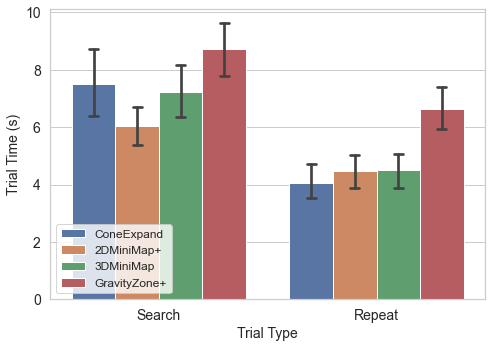

In [12]:
# need to group by [subject, technique, trial_type]
# technique_type_df = dfs_no_outliers_per_condition.groupby(["subject_id", "technique", "trial_type"]).mean().reset_index()

technique_type_df = dfs_no_outliers_per_condition[["subject_id", "technique", "trial_type", "density", "trial_time"]]
technique_type_df = technique_type_df.groupby(["subject_id", "technique", "trial_type", "density"]).mean().reset_index()
technique_type_df = technique_type_df.groupby(["subject_id", "technique", "trial_type"]).mean().reset_index()

# sorty by trial_type, then by technique, then by subject
technique_type_df.sort_values(by=["trial_type", "technique", "subject_id"], inplace=True)

technique_type_df.to_csv("df_for_first_plot_YES.csv", index=False)

fig, ax = plt.subplots(figsize=(7, 5))

# plot condensed data
sns.barplot(
    data=technique_type_df,
    x="trial_type",
    y="trial_time", 
    hue="technique", 
    hue_order=[o[1] for o in order], 
    order=["Search", "Repeat"], 
    ci=95,
    ax=ax,
    capsize=0.04,
)

handles, labels = ax.get_legend_handles_labels()
labels = [o[1] for o in order]
ax.legend(handles=handles[:], labels=labels[:], loc="lower left", fontsize=12)
# ax.legend(fontsize=5, loc="lower left")

# set axis font size
ax.tick_params(axis='both', which='major', labelsize=14)

# set outer labels
ax.set_xlabel("Trial Type", fontsize=14)
ax.set_ylabel("Trial Time (s)", fontsize=14)

fig.tight_layout()

fig.savefig("trial_time_by_condition.pdf", bbox_inches="tight")

In [41]:
# now that we have two of these dataframes, we can check the difference between them:
values_1 = technique_type_df["trial_time"].values
values_2 = df_for_first_plot["trial_time"].values

for i in range(len(values_1)):
    diff = values_1[i] - values_2[i]
    if diff > 0.00000000000001:
        print(i, diff)
    # print(values_1[i] - values_2[i])

In [44]:
def plot_shit_using_df(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.barplot(
        data=df,
        x="trial_type",
        y="trial_time", 
        hue="technique", 
        hue_order=[o[1] for o in order], 
        order=["Search", "Repeat"], 
        ci=95,
        ax=ax,
        capsize=0.04,
    )
    handles, labels = ax.get_legend_handles_labels()
    labels = [o[1] for o in order]
    ax.legend(handles=handles[:], labels=labels[:], loc="lower left", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel("Trial Type", fontsize=14)
    ax.set_ylabel("Trial Time (s)", fontsize=14)
    fig.tight_layout()
    return fig

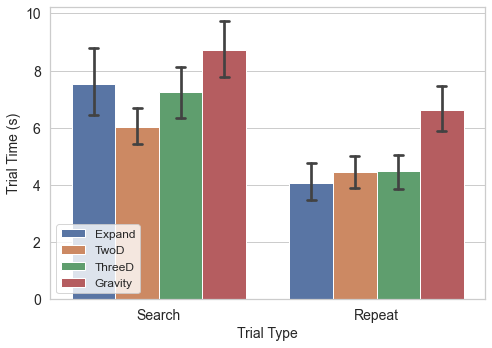

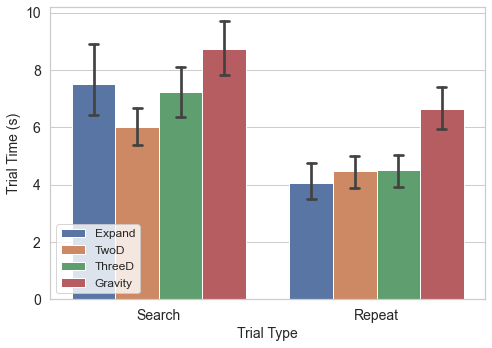

In [50]:
new_rows = []
for trial_type in dfs_no_outliers_per_condition.trial_type.unique():

    for technique in dfs_no_outliers_per_condition.technique.unique():
        for subject in dfs_no_outliers_per_condition.subject_id.unique():
            density_values = []
            for density in dfs_no_outliers_per_condition.density.unique():
                value = dfs_no_outliers_per_condition[
                    (dfs_no_outliers_per_condition["trial_type"] == trial_type) &
                    (dfs_no_outliers_per_condition["technique"] == technique) &
                    (dfs_no_outliers_per_condition["subject_id"] == subject) &
                    (dfs_no_outliers_per_condition["density"] == density)
                ]["trial_time"].values.mean()
                density_values.append(value)
            density_mean = np.mean(density_values)
            row = {
                "trial_type": trial_type,
                "technique": technique,
                "subject_id": subject,
                "trial_time": density_mean,
            }
            new_rows.append(row)

df_for_first_plot = pd.DataFrame(new_rows)
df_for_first_plot.sort_values(by=["trial_type", "technique", "subject_id"], inplace=True)

technique_type_df = dfs_no_outliers_per_condition[["subject_id", "technique", "trial_type", "density", "trial_time"]]
technique_type_df = technique_type_df.groupby(["subject_id", "technique", "trial_type", "density"]).mean().reset_index()
technique_type_df = technique_type_df.groupby(["subject_id", "technique", "trial_type"]).mean().reset_index()
technique_type_df.sort_values(by=["trial_type", "technique", "subject_id"], inplace=True)

# now that we have two of these dataframes, we can check the difference between them:
values_1 = technique_type_df["trial_time"].values
values_2 = df_for_first_plot["trial_time"].values

for i in range(len(values_1)):
    diff = np.abs(values_1[i] - values_2[i])
    if diff > 0.0000000000001:
        print(i, diff)

plot_shit_using_df(df_for_first_plot).savefig("trial_time_by_condition_2.pdf")
plot_shit_using_df(technique_type_df).savefig("trial_time_by_condition_3.pdf")

In [51]:
# # need to group by [subject, technique, trial_type]
# technique_type_df = dfs_no_outliers_per_condition.groupby(["subject_id", "technique", "trial_type", "density"]).mean().reset_index()

# fig, ax = plt.subplots(figsize=(7, 5))

# # plot condensed data
# sns.barplot(
#     data=technique_type_df,
#     x="trial_type",
#     y="trial_time", 
#     hue="technique", 
#     hue_order=[o[1] for o in order], 
#     order=["Search", "Repeat"], 
#     ci=95,
#     ax=ax,
#     capsize=0.04,
# )

# handles, labels = ax.get_legend_handles_labels()
# labels = [o[1] for o in order]
# ax.legend(handles=handles[:], labels=labels[:], loc="lower left", fontsize=12)
# # ax.legend(fontsize=5, loc="lower left")

# # set axis font size
# ax.tick_params(axis='both', which='major', labelsize=14)

# # set outer labels
# ax.set_xlabel("Trial Type", fontsize=14)
# ax.set_ylabel("Trial Time (s)", fontsize=14)

# fig.tight_layout()

# fig.savefig("trial_time_by_condition.pdf", bbox_inches="tight")

## Plot the second graph with columns for density levels

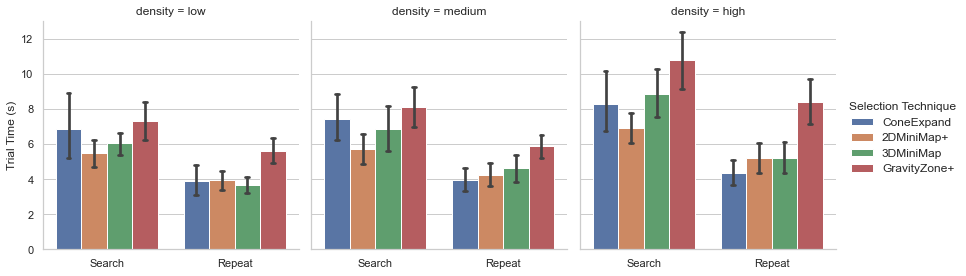

In [13]:
technique_type_density_df = dfs_no_outliers_per_condition.groupby(["subject_id", "technique", "trial_type", "density"]).mean().reset_index()

g = sns.catplot(
    data=technique_type_density_df,
    x="trial_type",
    y="trial_time",
    hue="technique",
    col="density",
    kind="bar",
    ci=95,
    height=4,
    aspect=1,
    # sharey=True,
    hue_order=[o[1] for o in order],
    order=["Search", "Repeat"],
    col_order=["low", "medium", "high"],
    capsize=0.03,
)
g.set_axis_labels("", "Trial Time (s)")

# set legend font size
g.legend.set_title("Selection Technique")
plt.setp(g.legend.get_texts(), fontsize='12')

g.tight_layout()

g.savefig("trial_time_by_condition_and_density.pdf", bbox_inches="tight", dpi=150)

## Condense down to Search and Repeat CSVs where rows are participants and columns are conditions

In [9]:
# Condense with DENSITY

for trial_type in dfs_no_outliers_per_condition.trial_type.unique():
    condensed_df = pd.DataFrame()
    for sub_idx in dfs_no_outliers_per_condition.subject_id.unique():
        subject_row = dict()
        subject_row["subject_id"] = sub_idx
        for technique in dfs_no_outliers_per_condition.technique.unique():
            for density in dfs_no_outliers_per_condition.density.unique():
                df = dfs_no_outliers_per_condition[
                    (dfs_no_outliers_per_condition["technique"] == technique) & 
                    (dfs_no_outliers_per_condition["trial_type"] == trial_type) & 
                    (dfs_no_outliers_per_condition["density"] == density) &
                    (dfs_no_outliers_per_condition["subject_id"] == sub_idx)
                ]
                if "Gravity" in technique:
                    t = "gravity"
                elif "3D" in technique:
                    t = "Three"
                elif "2D" in technique:
                    t = "Two"
                else:
                    t = "Cone"
                subject_row["_".join([t, density])] = df["trial_time"].mean()
        condensed_df = pd.concat([condensed_df, pd.DataFrame(subject_row, index=[0])])
    condensed_df.to_csv("condensed_df_" + trial_type + ".csv", index=False)

In [6]:
# Condense without DENSITY

for trial_type in dfs_no_outliers_per_condition.trial_type.unique():
    condensed_df = pd.DataFrame()
    for sub_idx in dfs_no_outliers_per_condition.subject_id.unique():
        subject_row = dict()
        subject_row["subject_id"] = sub_idx
        for technique in dfs_no_outliers_per_condition.technique.unique():
            # for density in dfs_no_outliers_per_condition.density.unique():
                df = dfs_no_outliers_per_condition[
                    (dfs_no_outliers_per_condition["technique"] == technique) & 
                    (dfs_no_outliers_per_condition["trial_type"] == trial_type) & 
                    # (dfs_no_outliers_per_condition["density"] == density) &
                    (dfs_no_outliers_per_condition["subject_id"] == sub_idx)
                ]
                subject_row["_".join([technique, trial_type])] = df["trial_time"].mean()
        condensed_df = pd.concat([condensed_df, pd.DataFrame(subject_row, index=[0])])
    condensed_df.to_csv("condensed_df_" + trial_type + ".csv", index=False)

In [ ]:
dfs

In [23]:
# condensed_df

## Some stats

In [36]:
technique_type_density_df = (
    dfs_no_outliers_per_condition.groupby(
        ["subject_id", "technique", "trial_type", "density"]
    )
    .mean()
    .reset_index()
)[["technique", "trial_type", "density", "trial_time"]]


In [39]:
technique = "Expand"

erl = technique_type_density_df[
    (technique_type_density_df["technique"] == technique) &
    (technique_type_density_df["trial_type"] == "Repeat") &
    (technique_type_density_df["density"] == "low")
    ]
# erh
# er

#  technique_type_density_df
erl

,technique,trial_type,density,trial_time
1,Expand,Repeat,low,2.185864
25,Expand,Repeat,low,3.547339
49,Expand,Repeat,low,7.323135
73,Expand,Repeat,low,9.998908
97,Expand,Repeat,low,2.007587
121,Expand,Repeat,low,1.664917
145,Expand,Repeat,low,2.149567
169,Expand,Repeat,low,6.571472
193,Expand,Repeat,low,2.503055
217,Expand,Repeat,low,4.162769


In [43]:
# Check for normality
for trial_type in dfs_no_outliers_per_condition.trial_type.unique():
    aggregated_df = pd.DataFrame()
    for technique in dfs_no_outliers_per_condition.technique.unique():
        # for density in dfs_no_outliers_per_condition.density.unique():
            rows = []
            for sub in dfs_no_outliers_per_condition.subject_id.unique():
                df = dfs_no_outliers_per_condition[
                    (dfs_no_outliers_per_condition["technique"] == technique)
                    & (dfs_no_outliers_per_condition["trial_type"] == trial_type)
                    # & (dfs_no_outliers_per_condition["density"] == density)
                    & (dfs_no_outliers_per_condition["subject_id"] == sub)
                ]
                sub_condition_time = df["trial_time"].mean()
                rows.append(
                    {
                        # "condition": f"{technique}_{trial_type}_{density}",
                        "condition": f"{technique}_{trial_type}",
                        "trial_time": sub_condition_time,
                    }
                )
            aggregated_df = pd.concat([aggregated_df, pd.DataFrame(rows)])
    aggregated_df.to_csv("test_normality_" + trial_type + ".csv", index=False)

# technique_type_df

# shapiro-wilk test


In [31]:
from scipy import stats

repeat = pd.read_csv("test_normality_Repeat.csv")
search = pd.read_csv("test_normality_Search.csv")



In [ ]:
import statsmodels.api as sm
import statsmodels.stats as stats
from statsmodels.formula.api import ols

In [ ]:
# # perform two-way ANOVA
# model = ols('trial_time ~ C(technique) + C(density) + C(trial_type) + C(technique):C(trial_type) + C(technique):C(density) + C(density):C(trial_type)', data=condensed_df).fit()
# sm.stats.anova_lm(model, typ=3)

# # do 2 separate two way for trial types

# # TODO run t tests on anova results with bonferroni correction

In [ ]:
# ANOVA with search only
condensed_search = condensed_df[condensed_df["trial_type"] == "Search"]
model = ols('trial_time ~ C(technique) + C(density) + C(technique):C(density)', data=condensed_search).fit()
sm.stats.anova_lm(model, typ=2)

In [ ]:
# res = ols("trial_time ~ C(technique)", data=condensed_search).fit()
# pw = res.t_test_pairwise("C(technique)", method="bonferroni")
# pw.result_frame

# res = ols("trial_time ~ C(technique) + C(density)", data=condensed_search).fit()
# pw = res.t_test_pairwise("C(technique)", method="bonferroni")
# pw.result_frame

# for level in condensed_search.density.unique():
#     print(level)
#     res = ols("trial_time ~ C(technique)", data=condensed_search[condensed_search["density"] == level]).fit()
#     pw = res.t_test_pairwise("C(technique)", method="bonferroni")
#     print(pw.result_frame)

res = ols("trial_time ~ C(density)", data=condensed_search).fit()
pw = res.t_test_pairwise("C(density)", method="bonferroni")
pw.result_frame

In [ ]:
# res = ols("trial_time ~ C(technique) + C(density)", data=condensed_search).fit()
# pw = res.t_test_pairwise("C(density)", method="bonferroni")
# pw.result_frame

In [ ]:
# ANOVA with repeat only
condensed_repeat = condensed_df[condensed_df["trial_type"] == "Repeat"]
model = ols('trial_time ~ C(technique) + C(density) + C(technique):C(density)', data=condensed_repeat).fit()
sm.stats.anova_lm(model, typ=2)

In [ ]:
# res = ols("trial_time ~ C(technique) + C(density)", data=condensed_repeat).fit()
# pw = res.t_test_pairwise("C(technique)", method="bonferroni")
# pw.result_frame

In [ ]:
res = ols("trial_time ~ C(density)", data=condensed_repeat).fit()
pw = res.t_test_pairwise("C(density)", method="bonferroni")
pw.result_frame

In [ ]:
from scipy.stats import f_oneway, ttest_ind, kstest

In [ ]:
# level = 1
# leveldf = condensed_df[condensed_df["density"] == level]

# flower = leveldf[leveldf["technique"] == "Flower"]["trial_time"]
# gravity_zone = leveldf[leveldf["technique"] == "GravityZone"]["trial_time"]
# oh_minimap = leveldf[leveldf["technique"] == "OhMiniMap"]["trial_time"]
# td_minimap = leveldf[leveldf["technique"] == "ThreeDMiniMap"]["trial_time"]

# # one-way anova
# res = f_oneway(flower, gravity_zone, oh_minimap, td_minimap)
# print(res)

# # pairwise t-tests
# res = ttest_ind(flower, gravity_zone)
# print("flower, gravity:", res)

# res = ttest_ind(flower, oh_minimap)
# print("flower, oh:", res)

# res = ttest_ind(flower, td_minimap)
# print("flower, td:", res)

# res = ttest_ind(gravity_zone, oh_minimap)
# print("gravity, oh:", res)

# res = ttest_ind(gravity_zone, td_minimap)
# print("gravity, td:", res)

# res = ttest_ind(oh_minimap, td_minimap)
# print("oh, td:", res)

In [ ]:
# loop t-tests over all levels

for task in condensed_df.trial_type.unique():

    print()
    print(task)

    for level in condensed_df.density.unique():
        leveldf = condensed_df[condensed_df["density"] == level]

        flower = leveldf[leveldf["technique"] == "ConeExpand"]["trial_time"]
        # gravity_zone = leveldf[leveldf["technique"] == "GravityZone"]["trial_time"]
        oh_minimap = leveldf[leveldf["technique"] == "2DMiniMap+"]["trial_time"]
        # td_minimap = leveldf[leveldf["technique"] == "3DMiniMap"]["trial_time"]

        # # normality test using kstest
        # print("ConeExpand is normal? ", kstest(flower, "norm").pvalue < 0.05)
        # print("GravityZone is normal? ", kstest(gravity_zone, "norm").pvalue < 0.05)
        # print("2DMiniMap+ is normal? ", kstest(oh_minimap, "norm").pvalue < 0.05)
        # print("3DMiniMap is normal? ", kstest(td_minimap, "norm").pvalue < 0.05)

        # continue

        techniques_vals = {
            "ConeExpand": flower,
            # "GravityZone": gravity_zone,
            "2DMiniMap+": oh_minimap,
            # "3DMiniMap": td_minimap,
        }

        print()
        print("Level: ", level)

        # # one-way anova
        # res = f_oneway(flower, gravity_zone, oh_minimap, td_minimap)
        # print(res)

        # pairwise t-tests
        for tv in techniques_vals:
            for tv2 in techniques_vals:
                
                if tv in ["ConeExpand", "GravityZone"] and tv2 in ["ConeExpand", "GravityZone"]:
                    continue

                if tv != tv2:
                    res = ttest_ind(techniques_vals[tv], techniques_vals[tv2])
                    if res.pvalue >= 0.05:
                        continue
                    print(f"{tv}, {tv2}:".ljust(30), res.statistic, res.pvalue, res.pvalue < 0.05)

In [ ]:
for task in condensed_df.trial_type.unique():

    print()
    print(task)

    # t tests for each level agains the other levels
    level1 = condensed_df[(condensed_df["density"] == 1) & (condensed_df["trial_type"] == task)]
    level2 = condensed_df[(condensed_df["density"] == 2) & (condensed_df["trial_type"] == task)]
    level3 = condensed_df[(condensed_df["density"] == 3) & (condensed_df["trial_type"] == task)]

    # level1 vs level2
    res = ttest_ind(level1["trial_time"], level2["trial_time"])
    print("level1 vs level2:", res.statistic, res.pvalue, res.pvalue < 0.05)

    # level1 vs level3
    res = ttest_ind(level1["trial_time"], level3["trial_time"])
    print("level1 vs level3:", res.statistic, res.pvalue, res.pvalue < 0.05)

    # level2 vs level3
    res = ttest_ind(level2["trial_time"], level3["trial_time"])
    print("level2 vs level3:", res.statistic, res.pvalue, res.pvalue < 0.05)

    print()

    # t tests for each technique agains the other techniques
    cone_expand = condensed_df[(condensed_df["technique"] == "ConeExpand") & (condensed_df["trial_type"] == task)]
    gravity_zone = condensed_df[(condensed_df["technique"] == "GravityZone") & (condensed_df["trial_type"] == task)]
    oh_minimap = condensed_df[(condensed_df["technique"] == "2DMiniMap+") & (condensed_df["trial_type"] == task)]
    td_minimap = condensed_df[(condensed_df["technique"] == "3DMiniMap") & (condensed_df["trial_type"] == task)]

    # cone_expand vs gravity_zone
    res = ttest_ind(cone_expand["trial_time"], gravity_zone["trial_time"])
    print("cone_expand vs gravity_zone:", res.statistic, res.pvalue, res.pvalue < 0.05)

    # cone_expand vs oh_minimap
    res = ttest_ind(cone_expand["trial_time"], oh_minimap["trial_time"])
    print("cone_expand vs oh_minimap:", res.statistic, res.pvalue, res.pvalue < 0.05)

    # cone_expand vs td_minimap
    res = ttest_ind(cone_expand["trial_time"], td_minimap["trial_time"])
    print("cone_expand vs td_minimap:", res.statistic, res.pvalue, res.pvalue < 0.05)

    # gravity_zone vs oh_minimap
    res = ttest_ind(gravity_zone["trial_time"], oh_minimap["trial_time"])
    print("gravity_zone vs oh_minimap:", res.statistic, res.pvalue, res.pvalue < 0.05)

    # gravity_zone vs td_minimap
    res = ttest_ind(gravity_zone["trial_time"], td_minimap["trial_time"])
    print("gravity_zone vs td_minimap:", res.statistic, res.pvalue, res.pvalue < 0.05)

    # oh_minimap vs td_minimap
    res = ttest_ind(oh_minimap["trial_time"], td_minimap["trial_time"])
    print("oh_minimap vs td_minimap:", res.statistic, res.pvalue, res.pvalue < 0.05)

In [18]:
search_times = dfs[dfs["trial_type"] == "Search"]["trial_time"]
repeat_times = dfs[dfs["trial_type"] == "Repeat"]["trial_time"]